In [1]:
# Importing some python libraries.
import numpy as np
from numpy.random import randn,rand
import matplotlib.pyplot as pl

from matplotlib.pyplot import plot

import seaborn as sns
%matplotlib inline

# Fixing figure sizes
from pylab import rcParams
rcParams['figure.figsize'] = 10,5



sns.set_palette('Reds_r')

# Reaction Network Homework

In this homework, we will study a very simple set of reactions by modelling it through three different ways. First, we shall employ an ODE model called the **Reaction Rate Equation**.  Then, we will solve the **Chemical Langevin Equation** and, finally, we will simulate the exact model by "solving" the **Chemical  Master Equation**. 

The reaction network of choice shall be a simple birth-death process, described by the relations : 

$$
\begin{align}
\emptyset \stackrel{a}{\to} X,\\
X \stackrel{\mu X}{\to} \emptyset.
\end{align}
$$

$X$ here is the population number.

Throughout, we shall use $a=10$ and $\mu=1.0$. 

## Reaction Rate Equation

The reaction rate equation corresponding to the system is 

$$
\begin{align}
\dot{x}=a-\mu\cdot x,\\
x(0)=x_0.
\end{align}
$$

As this is a linear equation, we can solve it exactly, with solution

$$
x(t)=x(t) = a/\mu+(x_0-a/\mu) e^{\mu (-t)}
$$



In [81]:
# Solution of the RRE
def x(t,x0=3,a=10.0,mu=1.0):
    return (x0-a/mu)*np.exp(-t*mu)+a/mu


We note that there is a stationary solution, $x(t)=a/\mu$. From the exponential in the solution, we can see that this is an attracting fixed point.

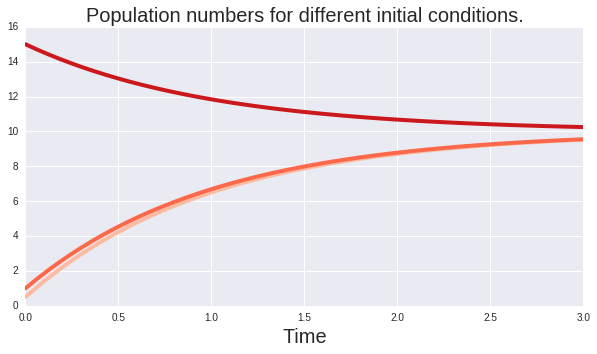

In [83]:
t = np.linspace(0,3)
x0list = np.array([0.5,1,15])

sns.set_palette("Reds",n_colors=3)

for x0 in x0list: 
 pl.plot(t,x(t,x0),linewidth=4)

pl.title('Population numbers for different initial conditions.', fontsize=20)
pl.xlabel('Time',fontsize=20)

# Chemical Langevin Equation

Next, we will model the system by using the CLE. For our particular birth/death process, this will be 

$$
dX_t=(a-\mu\cdot X_t)dt+(\sqrt{a}-\sqrt{\mu\cdot X_t})dW.
$$

To solve this, we shall use the Euler-Maruyama scheme from the previous homework. We fix a $\Delta t$ positive. Then, the scheme shall be : 

$$
X_{n+1}=X_n+(a-\mu\cdot X_n)\Delta t+(\sqrt{a}-\sqrt{\mu\cdot X_t})\cdot \sqrt{\Delta t}\cdot z,\ z\sim N(0,1).
$$

In [4]:
def EM(xinit,T,Dt=0.1,a=1,mu=2):
    '''
        Returns the solution of the CLE with parameters a, mu
        
        Arguments
        =========
        xinit : real, initial condition.
        Dt    : real, stepsize of the Euler-Maruyama.
        T     : real, final time to reach.
        a     : real, parameter of the RHS. 
        mu    : real, parameter of the RHS.
    
    '''
    
    n = int(T/Dt) # number of steps to reach T
    X = np.zeros(n)
    z = randn(n)
    
    X[0] = xinit # Initial condition
    
    # EM method 
    for i in xrange(1,n):
        X[i] = X[i-1] + Dt* (a-mu*X[i-1])+(np.sqrt(a)-np.sqrt(mu*X[i-1]))*np.sqrt(Dt)*z[i]
        
    return X
        

Similarly to the previous case, here is a run with multiple initial conditions. 

Paths decay towards 10.0004633499
The stationary point is 1.0


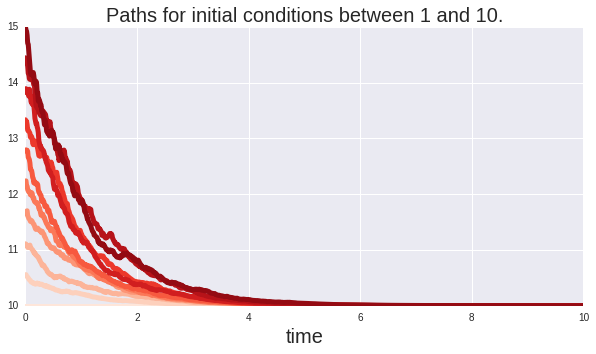

In [84]:
T = 10 # final time to reach
Dt = 0.01 # time-step for EM

# Set the palette to reds with ten colors
sns.set_palette('Reds',10)

def plotPaths(T,Dt):
    n = int(T/Dt)
    t = np.linspace(0,T,n)

    xinitlist = np.linspace(10,15,10)

    for x0 in xinitlist : 
        path = EM(xinit=x0,T=T,Dt=Dt,a=10.0,mu=1.0)
        pl.plot(t, path,linewidth=5)

    pl.xlabel('time', fontsize=20)
    pl.title('Paths for initial conditions between 1 and 10.', fontsize=20)
    
    return path
    
path = plotPaths(T,Dt)

print 'Paths decay towards', path[np.size(path)-1]
print 'The stationary point is', 1.0

We notice that the asymptotic behavior of the CLE is the same as that of the RRE. The only notable difference is the initial random kicks in the paths, all because of the stochasticicity. 


## Chemical Master Equation

Finally, we shall simulate the system exactly by using the Stochastic Simulation Algorithm (SSA). 

In [75]:
def SSA(xinit, nsteps, a=10.0, mu=1.0):
    '''
        Using SSA to exactly simulate the death/birth process starting
        from xinit and for nsteps. 
        
        a and mu are parameters of the propensities.
        
        Returns
        =======
        path : array-like, the path generated. 
        tpath: stochastic time steps
    '''
    
   
    path = np.zeros(nsteps)
    tpath= np.zeros(nsteps)
    
    path[0] = xinit # initial population
    
    u = rand(2,nsteps) # pre-pick all the uniform variates we need
    
    for i in xrange(1,nsteps):
        
        # The propensities will be normalized
        tot_prop = path[i-1]*mu+a
        prob = path[i-1]*mu/tot_prop # probability of death 
        
        if(u[0,i]<prob):
            # Death 
            path[i] = path[i-1]-1 
        else:
            # Birth
            path[i] = path[i-1]+1
            
        # Time stayed at current state    
        tpath[i] = -np.log(u[1,i])*1/tot_prop
        
       
    tpath = np.cumsum(tpath)
    return path, tpath  

Now that we have SSA setup, we can run multiple paths and compare the results to the previous cases.

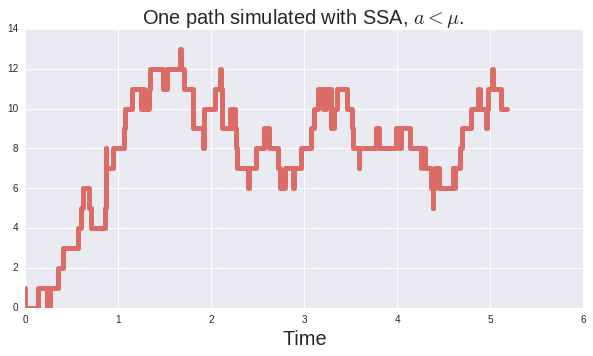

In [76]:
# Since the paths below are not really related
# let's use a more interesting palette 
# for the plot. 

sns.set_palette('hls',1)

for _ in xrange(1):
    path, tpath = SSA(xinit=1,nsteps=100)

    # Since this is the path of a jump process
    # I'm switching from "plot" to "step" 
    # to get the figure right. :) 
    pl.step(tpath,path,linewidth=5,alpha=0.9)

pl.title('One path simulated with SSA, $a<\mu$. ', fontsize=20);
pl.xlabel('Time', fontsize=20)



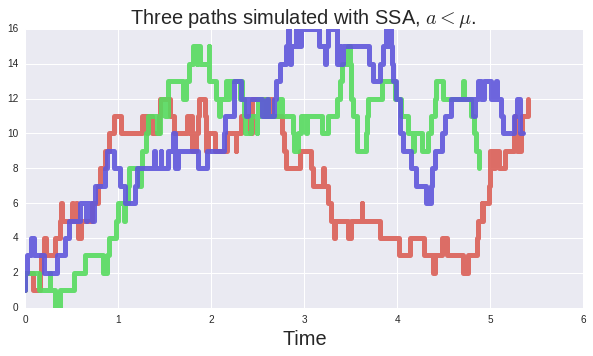

In [86]:
# Since the paths below are not really related
# let's use a more interesting palette 
# for the plot. 

sns.set_palette('hls',3)

for _ in xrange(3):
    path, tpath = SSA(xinit=1,nsteps=100)

    # Since this is the path of a jump process
    # I'm switching from "plot" to "step" 
    # to get the figure right. :) 
    pl.step(tpath,path,linewidth=5,alpha=0.9)

pl.title('Three paths simulated with SSA, $a<\mu$. ', fontsize=20);
pl.xlabel('Time', fontsize=20)


We can see three chains above, all starting from $X_0=10$, and simulated with the SSA. Since the constant that controls the birth rate is smaller than the one controlling the death rate, we see a constant decline of the population in either case.

In [85]:
npaths = 1
nsteps = 30000

path = np.zeros([npaths,nsteps])
for i in xrange(npaths):
    path[i,:], tpath = SSA(xinit=1,nsteps=nsteps)

skip = 20000
sum(path[0,skip:nsteps-1]*tpath[skip:nsteps-1])/sum(tpath[skip:nsteps-1])

10.550243180622136